In [1]:
import pandas as pd
import statsmodels.api as sm
from scipy import interpolate
from pandas import Series, DataFrame, Panel
from string import ascii_lowercase as letters
from scipy.stats import chisqprob
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from scipy.stats import wrapcauchy
import matplotlib.pyplot as plt
%matplotlib inline
%precision 4
plt.style.use('classic')
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
np.random.seed(1234)

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def rw2(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    distance=[]
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
        distance.append(r)
    return(x,y,distance,theta)  
    
n=1000 #int(input("how many steps?"))
alpha=2 #int(input("what's the scale?"))
beta=5 #int(input("what's the shape?"))
c=0.9# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1
data = rw2(n)
x=data[0]
y=data[1]
r_original=data[2]# this is a vector of step-lengths
theta_original=data[3]# this is a vector of headings
t=range(0,n)

In [3]:
# my code pretty much starts here
time_step=2
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [4]:
x_new=f(t_new)
y_new=g(t_new)

In [5]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))

499
499
499
498
498


In [6]:
def log_likelihood(x,a,b):# a is shape, b is scale
     return sum(dweibull.logpdf(x,scale=b,c=a))
def log_wclikelihood(x,a,b):
     return sum(wrapcauchy.logpdf(x,c=a,loc=b))# c is the shape parameter#MCMC sampler for the heading

In [7]:
# Now put them into the MCMC sampler, the second model is to be considered
import scipy.stats 
from scipy.stats import dweibull#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.075 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

#0.02

Acceptance rate = 0.343


0.818380200377
0.818402417588
18856


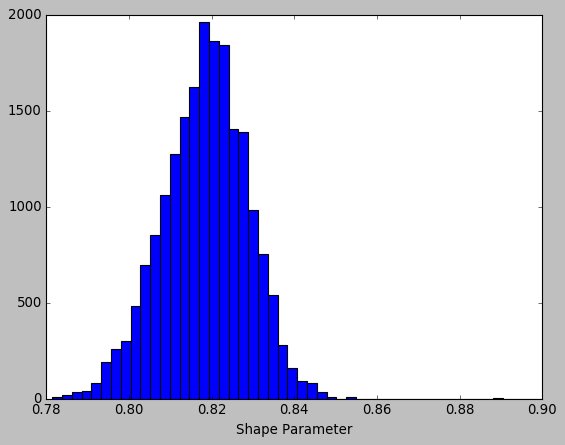

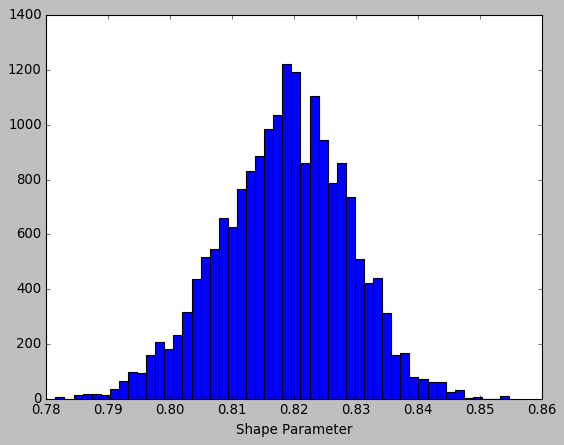

In [8]:
print(np.mean(A1))
print(np.mean(A1[1000:]))# burn in 1000
plt.hist(A1,bins=50)
B1=np.array(A1[1000:])
print(len(B1))
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()

In [9]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.2,0.2] # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 25,000 iterations.
for p in range(25000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))
#0.06

Acceptance rate = 0.3473


25001
6.18663504868
3.80730816706


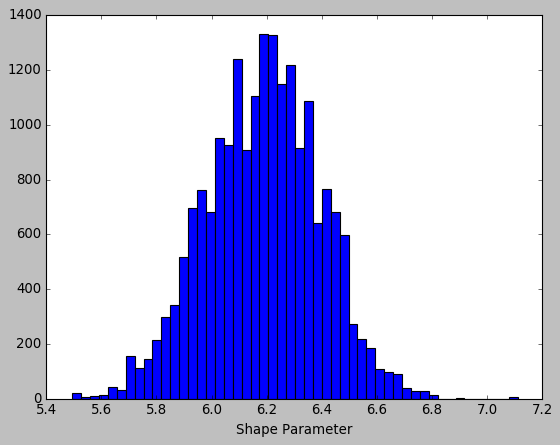

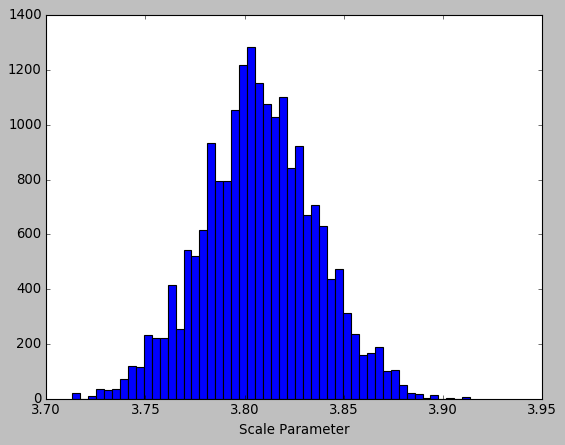

In [10]:
print(len(A2))
B2=np.array(A2[5000:])#burn-in 1000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)# now changing the parameters and n with the ones that I got
plt.xlabel("Scale Parameter")
plt.show()# now changing the parameters and n with the ones that I got



In [15]:
# Weibull
shape_parameters=B2[:,0]
scale_parameters=B2[:,1]
# select every 10th observation
shape_parameters_need=shape_parameters[::10][:-1801]# same length now
scale_parameters_need=scale_parameters[::10][:-1801]
#Wrapped Cauchy
shapewc_parameters=B1
shapewc_parameters_need=B1[::10][:-1686]
print(len(shapewc_parameters_need))
print(len(scale_parameters_need))
print(len(shape_parameters_need))

200
200
200


In [16]:
def rw2_change(n_change,alpha_change,beta_change,c_change):# this gives samples from the inference model
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=np.zeros(n_change)
    distance=[]
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance.append(r)# save the distances r for the mcmc sampler
    return [x_change,y_change,distance,theta]   
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_parameters_need#int(input("what's the scale?"))
beta_change=shape_parameters_need #int(input("what's the shape?"))
c_change=shapewc_parameters_need# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1
#x_change = np.array(rw2_change(n_change)[0])
#y_change=np.array(rw2_change(n_change)[1])
#data_change=np.array(rw2_change(n_change)[2])
#theta_change=np.array(rw2_change(n_change)[3])
#the previous code


In [17]:
print(scale_parameters_need)
print(shape_parameters_need)
print(shapewc_parameters_need)
print(n_change)

[ 3.7437  3.819   3.8213  3.8213  3.821   3.8385  3.7974  3.7974  3.7974
  3.7804  3.7886  3.8492  3.8492  3.8454  3.7396  3.8114  3.7902  3.7958
  3.7958  3.8077  3.8077  3.8043  3.8     3.8375  3.7647  3.8542  3.8189
  3.7707  3.8114  3.7841  3.8312  3.8     3.8     3.8186  3.8186  3.822
  3.822   3.822   3.822   3.8399  3.8426  3.8286  3.8286  3.8286  3.8122
  3.8137  3.8298  3.7342  3.7522  3.8426  3.7945  3.7945  3.7945  3.7773
  3.8537  3.8207  3.8     3.8354  3.7603  3.7989  3.7989  3.7776  3.7776
  3.7776  3.7776  3.817   3.8178  3.8194  3.8483  3.7598  3.8685  3.8685
  3.7916  3.7852  3.7976  3.7976  3.7894  3.8042  3.7809  3.7809  3.7647
  3.7343  3.7845  3.8057  3.8445  3.8326  3.8326  3.7958  3.7976  3.7976
  3.7976  3.8157  3.8157  3.7528  3.8308  3.7931  3.8209  3.794   3.794
  3.8019  3.8019  3.8013  3.8013  3.8372  3.8022  3.8022  3.8192  3.8192
  3.8749  3.7905  3.8154  3.7821  3.8482  3.7846  3.7703  3.8077  3.8476
  3.7802  3.7802  3.7815  3.7815  3.8328  3.8175  3.8

In [18]:
print(len(shapewc_parameters_need))
print(len(scale_parameters_need))
print(len(shape_parameters_need))
#make them the same size, check again

200
200
200


In [19]:
length_datas=len(t_new)

In [20]:
data_change=np.zeros((len(shape_parameters_need),length_datas-1))
theta_change=np.zeros((len(shapewc_parameters_need),length_datas))
# do arrays, matrices#if you want to make them the same size

In [21]:
#if you want to make them the same size
print(len(theta_change))
print(len(theta_original))
print(len(r_original))
print(len(data_change))
#Let's go to 999 then
#theta_change=theta_change[:999]
#theta_original=theta_original[:999]
#data_change=data_change[:999]
#shape_parameters_need=shape_parameters_need[:999]
#scale_parameters_need=scale_parameters_need[:999]
#shapewc_parameters_need=shapewc_parameters_need[:999]

200
1000
999
200


In [22]:
# the mean of the inferred parameters
mean_shape_weibullparameter=np.mean(shape_parameters)
mean_scale_weibullparameter=np.mean(scale_parameters)
mean_shape_wcparameter=np.mean(shapewc_parameters)

In [23]:
for i in range(len(shape_parameters_need)):
                     data_change[i]=np.array(rw2_change(length_datas,alpha_change[i],beta_change[i],c_change[i])[2])#the distances
#the same size as n

In [24]:
for i in range(len(shape_parameters_need)):
                     theta_change[i]=np.array(rw2_change(length_datas,alpha_change[i],beta_change[i],c_change[i])[3])#the angles
# the same size as n        

In [25]:
#calculate T_y for the downsampled data i.e. new data obtained after interpolation
T_y_weibull=log_likelihood(data,mean_shape_weibullparameter,mean_scale_weibullparameter)
T_y_wc=log_wclikelihood(new_data,mean_shape_wcparameter,0)
# T_y in total
T_y=T_y_weibull+T_y_wc
T_y

-1167.6486

In [26]:
print(len(data_change))
print(len(theta_change))
print(len(data))
print(len(new_data))

200
200
498
498


In [27]:
#data_change-step-lengths after the change of the parameters after inference
#theta_change-headings after the change of the parameters after inference

In [28]:
T_y_rep_weibull=np.zeros(len(shape_parameters_need))
for i in range(len(shape_parameters_need)):
    T_y_rep_weibull[i]=log_likelihood(data_change[i],shape_parameters_need[i],scale_parameters_need[i])

In [29]:
print(len(T_y_rep_weibull))


200


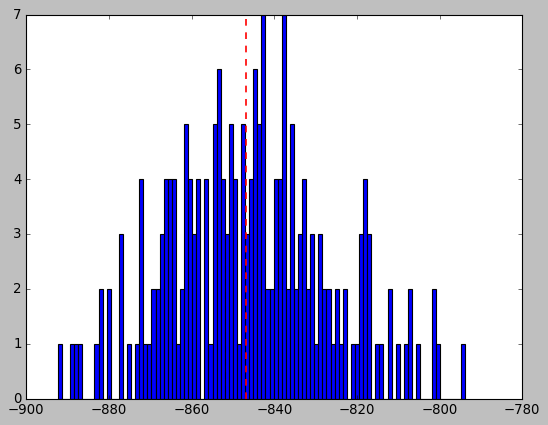

[-817.0542 -864.7477 -838.7047 -868.2614 -835.5923 -865.078  -886.8708
 -855.7304 -857.9758 -849.6542 -872.9756 -869.8511 -835.4116 -859.6171
 -837.6544 -850.6541 -864.2423 -847.1131 -845.8261 -854.5859 -865.9384
 -839.9905 -863.8295 -869.4247 -845.466  -882.0424 -837.581  -876.6759
 -849.7877 -845.0799 -875.1883 -851.8882 -851.4634 -832.331  -834.7094
 -825.1942 -842.1616 -841.0134 -807.123  -880.3548 -843.3472 -871.9933
 -854.889  -830.2298 -830.5035 -827.9291 -801.3983 -807.5186 -847.7464
 -864.4463 -858.386  -840.4833 -842.2473 -804.7754 -833.4989 -862.9574
 -862.2016 -868.104  -814.8109 -876.8301 -861.2165 -865.25   -858.5633
 -867.0146 -832.2317 -825.7217 -832.2195 -817.356  -869.116  -835.9653
 -860.3481 -877.3708 -864.9813 -838.5477 -837.3224 -842.3784 -862.4786
 -852.6017 -865.2087 -839.5732 -892.351  -856.8894 -845.0956 -859.4047
 -871.9434 -853.11   -841.2347 -879.9488 -834.4319 -849.2822 -845.6117
 -847.9728 -856.7338 -836.636  -853.8642 -814.302  -855.9625 -852.0987
 -867.

In [30]:
#Histogram just for the Weibull
plt.hist(T_y_rep_weibull,bins=100)
plt.axvline(T_y_weibull,linestyle='dashed', linewidth=1.5,color='red')
plt.show()
print(T_y_rep_weibull)
print(T_y_weibull)


In [31]:
count_zeros=0
for i in range(len(shape_parameters_need)):
    if T_y_rep_weibull[i]==0:
        count_zeros+=1
count_zeros

0

In [32]:
T_y_rep_wc=np.zeros(len(shapewc_parameters_need))
for i in range(len(shapewc_parameters_need)):
    T_y_rep_wc[i]=log_wclikelihood(theta_change[i],shapewc_parameters_need[i],0)


In [33]:
count_zeros=0
for i in range(len(shapewc_parameters_need)):
    if T_y_rep_wc[i]==0:
        count_zeros+=1
count_zeros

0

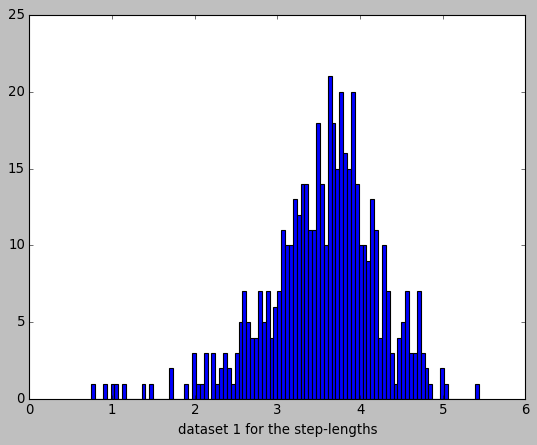

In [34]:
#print(data_change[1])
#print(data)# these two are very similar
#Histogram for the step-lengths data,
plt.hist(data,bins=100)
plt.xlabel('dataset 1 for the step-lengths')
plt.show()

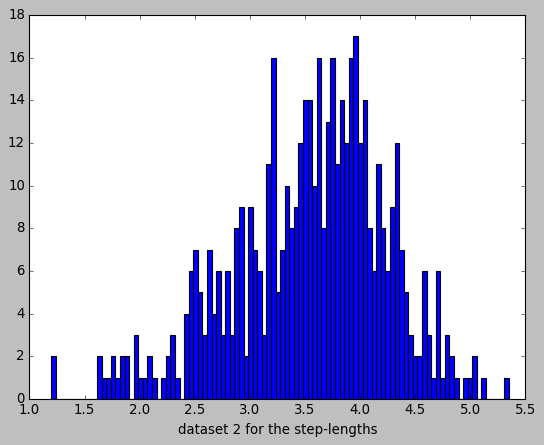

In [35]:
plt.hist(data_change[1],bins=100)
plt.xlabel('dataset 2 for the step-lengths')
plt.show()

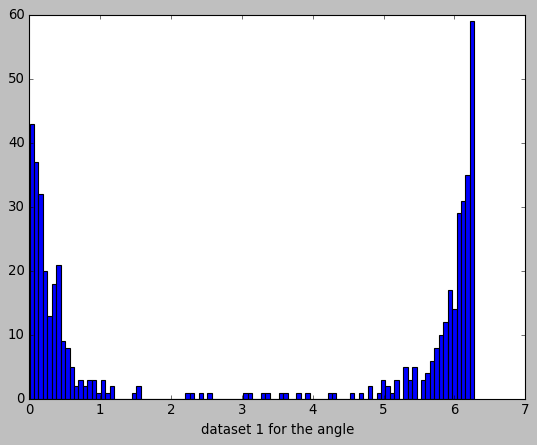

In [36]:
plt.hist(new_data,bins=100)
plt.xlabel('dataset 1 for the angle')
plt.show()

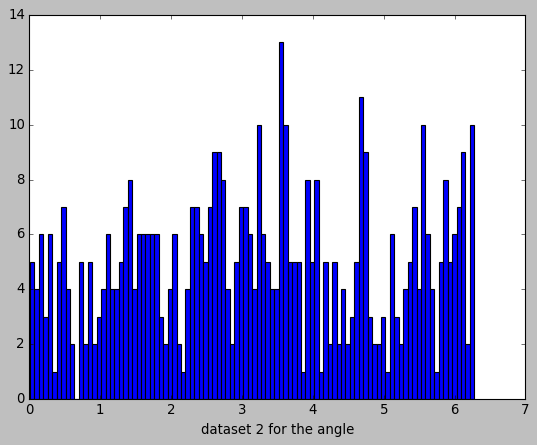

In [37]:
plt.hist(theta_change[1],bins=100)
plt.xlabel('dataset 2 for the angle')
plt.show()

In [38]:
#print(new_data)
#print(theta_change[1])


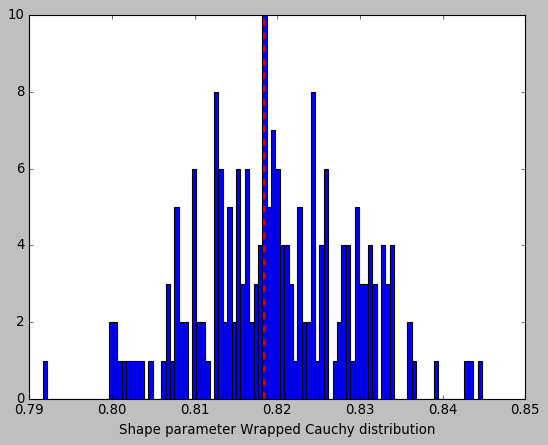

In [39]:
plt.hist(shapewc_parameters_need,bins=100)
plt.xlabel('Shape parameter Wrapped Cauchy distribution')
plt.axvline(mean_shape_wcparameter,linestyle='dashed', linewidth=1.5,color='red')
plt.show()

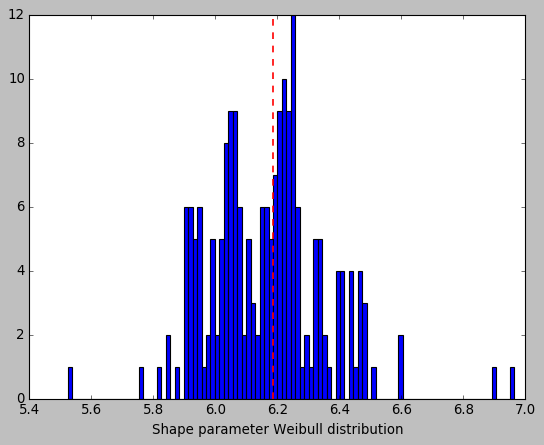

In [40]:
plt.hist(shape_parameters_need,bins=100)
plt.xlabel('Shape parameter Weibull distribution')
plt.axvline(mean_shape_weibullparameter,linestyle='dashed', linewidth=1.5,color='red')
plt.show()

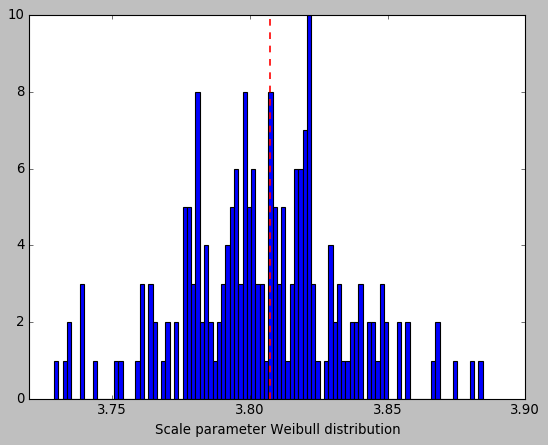

In [41]:
plt.hist(scale_parameters_need,bins=100)
plt.xlabel('Scale parameter Weibull distribution')
plt.axvline(mean_scale_weibullparameter,linestyle='dashed', linewidth=1.5,color='red')
plt.show()

In [42]:
print(len(T_y_rep_wc))
#T_y_rep_wc

200


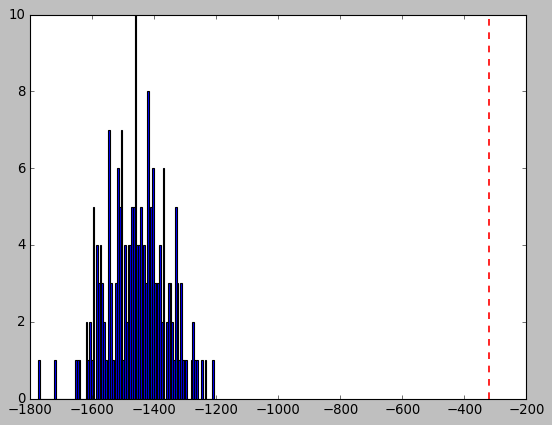

[-1415.4826 -1511.1947 -1459.3653 -1651.0832 -1451.3824 -1511.3177
 -1507.0917 -1399.2718 -1469.6311 -1339.3525 -1516.1873 -1374.6302
 -1612.8553 -1392.7994 -1545.1177 -1481.108  -1412.9791 -1346.9954
 -1384.7255 -1357.3148 -1443.3694 -1391.063  -1272.6709 -1547.2257
 -1584.3692 -1404.7336 -1465.1074 -1337.1404 -1451.1746 -1505.1946
 -1448.7231 -1480.2767 -1417.6661 -1327.5241 -1533.5661 -1452.4934
 -1503.3607 -1419.1153 -1466.7231 -1542.102  -1461.42   -1372.6724
 -1593.5048 -1517.4652 -1440.7893 -1616.7347 -1569.924  -1596.4813
 -1329.6544 -1569.1028 -1421.2563 -1578.8337 -1608.4305 -1483.1672
 -1459.975  -1331.6281 -1488.4506 -1721.3457 -1512.3308 -1418.2307
 -1578.3847 -1576.2541 -1402.03   -1435.013  -1433.7168 -1542.2399
 -1471.5895 -1409.1681 -1464.4316 -1351.0519 -1351.6361 -1459.0594
 -1370.6824 -1389.6846 -1560.4776 -1401.6093 -1543.2668 -1546.9561
 -1440.9034 -1564.4268 -1428.7519 -1324.2227 -1557.5744 -1405.8343
 -1467.9999 -1516.9047 -1571.8456 -1379.7086 -1342.3578 -1574.

In [43]:
#Histogram for the Wrapped Cauchy, the difference lies here
plt.hist(T_y_rep_wc,bins=100)
plt.axvline(T_y_wc,linestyle='dashed', linewidth=1.5,color='red')
plt.show()
print(T_y_rep_wc)
print(T_y_wc)


In [44]:
T_y_rep=T_y_rep_weibull+T_y_rep_wc   
#T_y_rep

In [45]:
count=0
for i in range(len(shape_parameters_need)):
    if T_y_rep[i]>T_y:
        count+=1
print(count)
print(len(shape_parameters_need))
ppp_value=count/len(shape_parameters_need)
print(ppp_value)


0
200
0.0


In [46]:
# see above for the histogram just for the test statistic for the weibull distributions

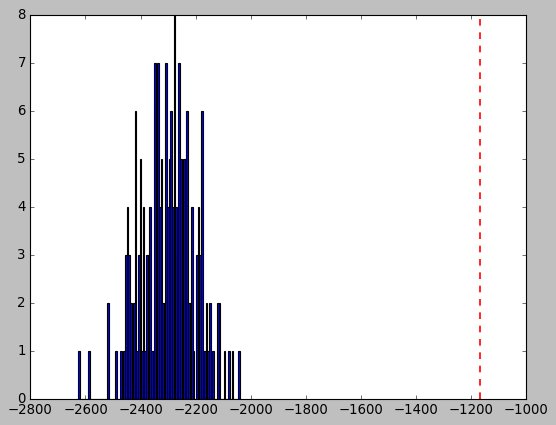

In [47]:
plt.hist(T_y_rep,bins=100)
plt.axvline(T_y,linestyle='dashed', linewidth=1.5,color='red')
plt.show()